[*]pcd loaded
[*]pcd loaded


Could not delete output dir: /tmp/autosklearn_output_1143_4602
Could not delete tmp dir: /tmp/autosklearn_tmp_1143_4602


[*]load model!
Data Loaded in 0.3706669807434082 seconds
100
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36]
[6.240292599326686e-05, 0.00018264187706841363, 0.00019936812551398026, 0.00025351151176120925, 0.0003264817324551669, 0.00036776065826416016, 0.0004386798195216967, 0.0005043853412974964, 0.0006210553018670333, 0.0007035732269287109, 0.0008989923140581916, 0.0011287997750674978, 0.0012538962894015843, 0.0015105824721486944, 0.0017292648553848267, 0.002382193292890276, 0.0023133571331317607, 0.0024814605712890625, 0.0027656371776874247, 0.002999246120452881, 0.0035578104165884163, 0.003791630268096924, 0.004198622703552246, 0.004562079906463623, 0.004770892007010323, 0.005289145878383091, 0.00584259033203125, 0.006449222564697266, 0.006660779317220052, 0.007406353950500488, 0.009198546409606934, 0.008054733276367188]


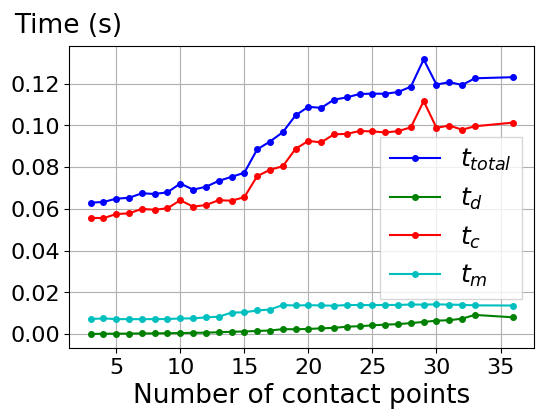

In [59]:
# %load planning_demo.py
from data_loader import *
import time
from sklearn.metrics import mean_squared_error
import math
from scipy import spatial
from copy import deepcopy
from klampt.math import se3,so3 
import matplotlib.pyplot as plt
from open3d import *
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

#import contact_force_solver_sphere
def invKernel(p1,p2,param):
    r = vo.norm(vo.sub(p1,p2))
    return param/(param+r)

def inRadius(pt,pts,radius):
    for ele in pts:
        if vo.norm(vo.sub(ele,pt)) < radius:
            return True
    return False

def create_sphere(radius,center,N):
    #create a sphere with approximately N surface points 
    #radius r, centered at center
    #seems like the original algorithm has a bug...
    #In the second like instead of using r^2, just set it to be 1
    print(N)
    OPEN3DVIS = True
    surface_points = []
    Ncount = 0
    a = 4.0*math.pi/float(N)
    d = math.sqrt(a)
    Mtheta = round(math.pi/d)
    dv = math.pi/float(Mtheta)
    dphi = a/dv
    for i in range(int(Mtheta)):
        theta = math.pi*(float(i)+0.5)/Mtheta
        Mphi = round(2.0*math.pi*math.sin(theta)/dphi)
        for j in range(int(Mphi)):
            phi = 2.0*math.pi*float(j)/Mphi
            pt = [math.sin(theta)*math.cos(phi),math.sin(theta)*math.sin(phi),math.cos(theta)]
            surface_points.append(vo.add(vo.mul(pt,radius),center))
            Ncount = Ncount + 1
    print('Ncount:',Ncount)
    ##display for debugging    
    if OPEN3DVIS:
        open3dPcd = PointCloud()
        xyz = []
        rgb = []
        for ele in surface_points:
            xyz.append(ele[0:3])
            rgb.append([1,0,0])
        open3dPcd.points = Vector3dVector(np.asarray(xyz,dtype=np.float32))
        open3dPcd.colors = Vector3dVector(np.asarray(rgb,dtype=np.float32))
        draw_geometries([open3dPcd,open3dPcd])
        
    return surface_points 

def predict_sphere(pcd,probedPcd,rigidSurfacePtsAll,param,model,offset,deformableCenter,rigidCenter,diameter,OPEN3DVIS = False):
    DEBUGPROJECTEDPTS = False
    DEBUGDISPLACEDPTS = False
    #print(len(pcd[0]))
    #OPEN3DVIS = False
    #create a pcd in open3D
    #if OPEN3DVIS:
    if OPEN3DVIS:
        open3dPcd = PointCloud()
        xyz = []
        rgb = []
        for ele in pcd:
            xyz.append(ele[0:3])
            rgb.append(ele[3:6])
        open3dPcd.points = Vector3dVector(np.asarray(xyz,dtype=np.float32))
        open3dPcd.colors = Vector3dVector(np.asarray(rgb,dtype=np.float32))

    ###calculate time
    startTime = time.time()

    #rigidSurfacePtsAll are expressed locally, centered at rigidCenter
    #let the approach vector be local z and global y be local x
    approachVector = vo.sub(deformableCenter,rigidCenter)
    approachVector = vo.div(approachVector,vo.norm(approachVector))
    localXinW = [0,1,-approachVector[1]/approachVector[2]]
    localXinW = vo.div(localXinW,vo.norm(localXinW))
    localYinW = vo.cross(approachVector,localXinW)
    localYinW = vo.div(localYinW,vo.norm(localYinW))
    ##now we have both localX and localY normalized...

    ####compute rigid surface pts both locally and globally
    # To save time, do not include all the pts
    rigidPointsLocal = []# 2D local rigid pts
    rigidPointsinW = []
    for pt in rigidSurfacePtsAll:
        pt = vo.add(pt,rigidCenter)
        tmp = vo.sub(pt,rigidCenter)
        tmp = vo.div(tmp,vo.norm(tmp))
        if vo.dot(tmp,approachVector) > 0.25:
            projectedPt = vo.sub(pt,vo.mul(approachVector,vo.dot(vo.sub(pt,rigidCenter),approachVector))) ##world frame
            projectedPt2D = vo.sub(projectedPt,rigidCenter) #world frame
            projectedPt2DinLocal = [vo.dot(projectedPt2D,localXinW),vo.dot(projectedPt2D,localYinW)]
            rigidPointsLocal.append(projectedPt2DinLocal)
            rigidPointsinW.append(pt)

    #############Now Start predicting force#####################

    ######## visualize in open3D for debugging ########
    #if OPEN3DVIS:
    if OPEN3DVIS:
        open3dCircularPcd = PointCloud()
        xyz = []
        rgb = []
        for ele in rigidPointsinW:
            xyz.append(ele[0:3])
            rgb.append([1,0,0])
        open3dCircularPcd.points = Vector3dVector(np.asarray(xyz,dtype=np.float32))
        open3dCircularPcd.colors = Vector3dVector(np.asarray(rgb,dtype=np.float32))
        draw_geometries([open3dPcd,open3dCircularPcd])

    
    ################# project the pcd to the local XY frame##############
    #The start point is the origin of the plane...
    projectedPcdinW = []
    projectedPcdLocal = [] 
    #the projected Pcd is in local frame....
    NofProjectedPoints = 0

    for i in range(len(pcd)):
        p = pcd[i][0:3]
        #### The way to select the point for the sphere is a bit different....
        if vo.norm(vo.sub(p,rigidCenter)) < (diameter/2.0+0.005):
            projectedPt = vo.sub(p,vo.mul(approachVector,vo.dot(vo.sub(p,rigidCenter),approachVector))) ##world origin
            projectedPt2D = vo.sub(projectedPt,rigidCenter)#world origin
            projectedPt2DinLocal = [vo.dot(projectedPt2D,localXinW),vo.dot(projectedPt2D,localYinW)]
            projectedPcdLocal.append(projectedPt2DinLocal)
            projectedPcdinW.append(pcd[i])

    if OPEN3DVIS:
        open3dPcd1 = PointCloud()
        xyz = []
        rgb = []
        for ele in projectedPcdinW:
            xyz.append(ele[0:3])
            rgb.append(ele[3:6])
        open3dPcd1.points = Vector3dVector(np.asarray(xyz,dtype=np.float32))
        open3dPcd1.colors = Vector3dVector(np.asarray(rgb,dtype=np.float32))
        draw_geometries([open3dCircularPcd,open3dPcd1])
    #print("number of projected deformable pts:",len(projectedPcdinW))
    ###############Find the corresponding points on the deformable object############
    surfacePtsAll = []# %These are the surface pts that will be displaced.
    rigidPointsFinal = []

    
    if len(projectedPcdinW) > 0:
        #Create a KDTree for searching
        projectedPcdTree = spatial.KDTree(projectedPcdLocal)
        #average 3 neighbors
        NofN = 3   
        for i in range(len(rigidPointsinW)):
            ptLocal = rigidPointsLocal[i][0:2]
            if len(projectedPcdinW)<NofN:
                NofNNew = len(projectedPcdinW)
            else:
                NofNNew = NofN
            d,Idx = projectedPcdTree.query(ptLocal,k=NofN)
            #We might end up having duplicated pts...
            #We should make sure that the discretization is not too fine..
            #or should average a few neighbors
            if d[0] < 0.002:
                surfacePt = [0]*10
                for j in range(NofNNew):
                    #print(Idx,Idx[i],len(projectedPcdinW))
                    surfacePt = vo.add(surfacePt,projectedPcdinW[Idx[j]][0:10])
                surfacePt = vo.div(surfacePt,NofN)
                #remove duplicates
                if not (surfacePt in surfacePtsAll):
                #if True:
                    surfacePtsAll.append(surfacePt)
                    rigidPointsFinal.append(rigidPointsinW[i][0:3])        
    
        surfacePts = [] #These are the surface pts that will be displaced...
        nominalD = [] #Column Vector..
        rigidPtsInContact = []
        for i in range(len(rigidPointsFinal)):
            rigidPt = rigidPointsFinal[i]
            surfacePt = surfacePtsAll[i][0:3]
            normal = surfacePtsAll[i][6:9]
            nominalDisp = -vo.dot(vo.sub(rigidPt,surfacePt),normal)
            if nominalDisp > 0:
                surfacePts.append(surfacePtsAll[i][0:10])#position in the global frame..
                nominalD.append(nominalDisp)
                rigidPtsInContact.append(rigidPt)

        if OPEN3DVIS:
            open3dPcd1 = PointCloud()
            xyz = []
            rgb = []
            for ele in surfacePts:
                xyz.append(ele[0:3])
                rgb.append(ele[3:6])
            open3dPcd1.points = Vector3dVector(np.asarray(xyz,dtype=np.float32))
            open3dPcd1.colors = Vector3dVector(np.asarray(rgb,dtype=np.float32))
            draw_geometries([open3dCircularPcd,open3dPcd1])

        #originalNominalD = deepcopy(nominalD)
        #print('Deformed Surface Points',surfacePts)
        #####Calculate actual displacements
        
        #turn things into numpy array
        surfacePts = np.array(surfacePts)
        nominalD = np.array(nominalD)
        NofSurfacePts = len(surfacePts)
        if NofSurfacePts > 0:
            startTimeSimulator = time.time()     
            negativeDisp = True
            while negativeDisp:
                NofSurfacePts = len(surfacePts)
                K = np.zeros((NofSurfacePts,NofSurfacePts))
                for i in range(NofSurfacePts):
                    for j in range(NofSurfacePts):
                        K[i][j] = invKernel(surfacePts[i][0:3],surfacePts[j][0:3],param)
                #print K
                

                #print nominalD,actualD
                #tmpTime = time.time()
                #if np.linalg.matrix_rank(K) == NofSurfacePts:
                #    actualD =  np.dot(np.linalg.inv(K),nominalD)
                #else:
                #    return -1,-1,-1,-1,-1
                #print('Calculate Rank Time:',time.time()-tmpTime)
                #tmpTime = time.time()
                actualD =  np.dot(np.linalg.inv(K),nominalD)
                #print('matrix_inversion',time.time()-tmpTime)

                #tmp2Time = time.time()
                negativeIndex = actualD < 0
                if np.sum(negativeIndex) > 0:
                    #print(len(surfacePts),len(nominalD),len(rigidPtsInContact))
                    #actualD = actualD.tolist()
                    #surfacePts = [surfacePts[i] for i in range(len(surfacePts)) if actualD[i]>=0]
                    #nominalD = [nominalD[i] for i in range(len(nominalD)) if actualD[i]>=0]
                    ####rigidPtsInContact = [rigidPtsInContact[i] for i in range(len(rigidPtsInContact)) if actualD[i]>=0]
                    positiveIndex = actualD >= 0
                    surfacePts = surfacePts[positiveIndex]
                    nominalD = nominalD[positiveIndex]
                else:
                    negativeDisp = False
                #print('delete row time',time.time()-tmp2Time-tmp3)
            #calculate force
            startTimePointModel = time.time()
            totalForce = 0
            Ns = len(surfacePts)
            queryPtsBeforeNormalization = []
            for i in range(Ns):
                #print(surfacePts[i][0:3],[nominalD[i]-actualD[i]])
                queryPt = np.hstack((surfacePts[i][0:3],[nominalD[i]-actualD[i]]))
                queryPtsBeforeNormalization.append(queryPt)
                #queryPts.append(queryPt)
            for i in range(Ns):
                queryPt = np.hstack((surfacePts[i][0:3],[nominalD[i]]))
                queryPtsBeforeNormalization.append(queryPt)
            #print(surfacePts)
            #print(nominalD)
            queryPts = normalize_points(np.array(queryPtsBeforeNormalization),offset[0:3],offset[3])
            #print(queryPts)    
            forces = model.predict(queryPts)
            #print(forces)
            for i in range(Ns): 
                force = forces[i+Ns]-forces[i]
                if force < 0:
                    force = 0
                totalForce = totalForce + force
            totalTime = time.time() - startTime
            calculationTime = time.time() - startTimeSimulator
            pointPredictionTime = time.time() - startTimePointModel
            return totalForce,totalTime,calculationTime,pointPredictionTime,len(rigidPtsInContact)
        else:
            totalForce = 0
    else:
        totalForce = 0
    
    totalTime = -1
    calculationTime = -1
    pointPredictionTime = -1

    return totalForce,totalTime,calculationTime,pointPredictionTime,-1


#MODE = 1 #run simulation
#MODE = 2 #plot
#MODE = 3
MODE = 4

startTime = time.time()
exp_N = '3'
################## Planning problem for sphere ######################
exp_path='../data_final/exp_' + exp_N + '/'
exp_path_2 = '../data_final/exp_' + exp_N + '_debiased/'
#load visual model
pcd = load_pcd(exp_path_2+'originalPcd.txt',pcdtype='return_lines')
#pcd = np.array(pcd)
probedPcd = load_pcd(exp_path+'probePcd.txt',pcdtype='return_lines')
points = np.array(pcd)
##calculate the range
max_range = max([ (np.max(points[:,0])-np.min(points[:,0])) , 
                (np.max(points[:,1])-np.min(points[:,1])) , 
                (np.max(points[:,2])-np.min(points[:,2])) ])
p_min = []
p_max = []
for i in range(3):
    p_min.append(np.min(points[:,i]))
    p_max.append(np.max(points[:,i]))

###shift the pcd..
pcd_shifted = []
for pt in pcd:
    pcd_shifted.append(vo.sub(pt[0:3],p_min)+pt[3:10])

probedPcd_shifted = []
for pt in probedPcd:
    probedPcd_shifted.append(vo.sub(pt[0:3],p_min)+pt[3:10])

##load point model
model_path = '../data_final/exp_' + exp_N +'_debiased/models/model_pt10.pkl'
model = load_model(model_path)
offset = p_min + [max_range]
print('Data Loaded in',time.time()-startTime,'seconds')


with open('ptest.txt', 'w') as filehandle:
    pass
#rigid object paramters
diameter = 0.04


if MODE == 1:
    #simulation parameter
    param = 0.03 # in meters
    discretization = 0.003 # in meters
    rigidSurfacePtsAll = create_sphere(diameter/2.0,[0,0,0],150)

    # search x-y grid
    gridDiscretization = 0.02
    box_gap = 0.01
    gridBoundX = [diameter/2.0 - box_gap, p_max[0]-p_min[0] - diameter/2.0 + box_gap]
    gridBoundY = [diameter/2.0 - box_gap, p_max[1]-p_min[1] - diameter/2.0 + box_gap]
    NX = round((gridBoundX[1] - gridBoundX[0])/gridDiscretization)
    NY = round((gridBoundY[1] - gridBoundY[0])/gridDiscretization)
    gridPtsX = np.linspace(gridBoundX[0],gridBoundX[1],int(NX))
    gridPtsY = np.linspace(gridBoundY[0],gridBoundY[1],int(NY))

    searchStartZ = p_max[2] - p_min[2] + diameter/2.0 + 0.001
    #deformableCenter = [(gridBoundX[0]+gridBoundX[1])/2.0,(gridBoundY[0]+gridBoundY[1])/2.0,0]
    forceThreshold = 2 
    searchDiscretization = 0.001
    minZs = []
    counter = 0
    #speedTest
    #speedTestTimes = []
    speedTestTimesDifferentNumberContactsPoints1 = []
    speedTestTimesDifferentNumberContactsPoints2 = []
    speedTestTimesDifferentNumberContactsPoints3 = []
    speedTestTimesDifferentNumberContactsPoints4 = []
    for i in range(100):
        speedTestTimesDifferentNumberContactsPoints1.append([0])
        speedTestTimesDifferentNumberContactsPoints2.append([0])
        speedTestTimesDifferentNumberContactsPoints3.append([0])
        speedTestTimesDifferentNumberContactsPoints4.append([0])
    #totalTime = 0
    #calculationTime = 0
    #pointPredictionTime = 0

    for x in gridPtsX:
        for y in gridPtsY:
            forceMagnitude = 0

            z = searchStartZ
            #x = 0.004
            #y = 0.15
            #y = 0.13335000000000002
            #x = 0.01
            #y = 0.09223333333333333
            #print('grid:',x,y)
            while(forceMagnitude < forceThreshold):
                rigidCenter = [x,y,z]
                deformableCenter = [x,y,0]
                print('rigicCenter',rigidCenter)
                if z >= diameter/2.0:
                    
                    # = predict_sphere(pcd_shifted,probedPcd_shifted,rigidSurfacePtsAll,param,model,offset,deformableCenter,rigidCenter,diameter,False)
                    force,totalTime,calculationTime,pointPredictionTime,NofContactPoints = predict_sphere(pcd_shifted,probedPcd_shifted,rigidSurfacePtsAll,param,model,offset,deformableCenter,rigidCenter,diameter,False)
                    if totalTime > 0:
                        ##total time for query once when there is contact; time spent doing collision detections
                        # time spent quering for point forces; time spent calculating actual displacements
                        speedTestTimesDifferentNumberContactsPoints1[NofContactPoints+1].append(totalTime)
                        speedTestTimesDifferentNumberContactsPoints2[NofContactPoints+1].append(totalTime - calculationTime)
                        speedTestTimesDifferentNumberContactsPoints3[NofContactPoints+1].append(pointPredictionTime)
                        speedTestTimesDifferentNumberContactsPoints4[NofContactPoints+1].append(calculationTime-pointPredictionTime)

                    z = z - searchDiscretization
                    forceMagnitude = math.fabs(force)
                    #print(force)
                    if forceMagnitude > forceThreshold:
                        minZs.append(vo.add(rigidCenter,[0,0,searchDiscretization]))
                        break
                else:
                    minZs.append([x,y,diameter/2.0])
                    break
            ## report the average
            #NofFrames = len(speedTestTimes)
            #total = [0,0,0,0]
            #print('sppedTestTimes',speedTestTimes)
            #for t in speedTestTimes:
            #    total = vo.add(t,total)
            #averageTime = vo.div(total,NofFrames)
            #print('averageTime',averageTime)
            #print('minZs',minZs[counter][2])
            #exit()
            #counter = counter + 1            
            #exit()        
    #with open('output.txt', 'w') as f:
    #    for  line in minZs:
    #        f.write(str(line[0]) + ' ')
    #        f.write(str(line[1]) + ' ')
    #        f.write(str(line[2]) + '\n')
    with open('speedTestOutput1.txt', 'w') as f:
        for  alist in speedTestTimesDifferentNumberContactsPoints1:
            for ele in alist:
                f.write(str(ele) + ' ')
            f.write('\n')
    with open('speedTestOutput2.txt', 'w') as f:
        for  alist in speedTestTimesDifferentNumberContactsPoints2:
            for ele in alist:
                f.write(str(ele) + ' ')
            f.write('\n')
    with open('speedTestOutput3.txt', 'w') as f:
        for  alist in speedTestTimesDifferentNumberContactsPoints3:
            for ele in alist:
                f.write(str(ele) + ' ')
            f.write('\n')
    with open('speedTestOutput4.txt', 'w') as f:
        for  alist in speedTestTimesDifferentNumberContactsPoints4:
            for ele in alist:
                f.write(str(ele) + ' ')
            f.write('\n')
    

if MODE == 2:
    open3dPcd = PointCloud()
    xyz = []
    rgb = []
    for ele in pcd_shifted:
        xyz.append(ele[0:3])
        rgb.append(ele[3:6]) 
    open3dPcd.points = Vector3dVector(np.asarray(xyz,dtype=np.float32))
    open3dPcd.colors = Vector3dVector(np.asarray(rgb,dtype=np.float32))
    #rigidCenter = [0.1,0.1,0.3]
    rigidCenter = [0.1,0,0.3]
    mesh_sphere = geometry.create_mesh_sphere(radius=diameter/2.0, resolution=30)
    sphere_transform = np.asarray(
                [[1, 0, 0,  rigidCenter[0]],
                [0, 1, 0,  rigidCenter[1]],
                [0, 0, 1, p_max[2]-p_min[2]+diameter/2.0+0.02],
                [0.0, 0.0, 0.0, 1.0]])
    mesh_sphere.transform(sphere_transform)
    mesh_sphere.paint_uniform_color([235.0/255.0, 62.0/255.0, 14.0/255.0])
    mesh_sphere.compute_vertex_normals()
    #create box
    #make the box a bit larger than the object
    box_gap = 0.01
    p_min[0] = p_min[0]
    p_max[0] = p_max[0]
    p_min[1] = p_min[1]
    p_max[1] = p_max[1]
    wallThickness = 0.005
    wallColor = [165.0/255.0, 111.0/255.0, 227.0/255.0]
    wallHeight = p_max[2]-p_min[2] + 0.03
    mesh_box_bottom = geometry.create_mesh_box(p_max[0]-p_min[0]+2.0*box_gap,p_max[1]-p_min[1]+2.0*box_gap,wallThickness) #x,y,z
    mesh_box_bottom.paint_uniform_color(wallColor)
    transform = np.asarray(
                [[1, 0, 0,  -box_gap],
                [0, 1, 0,  -box_gap],
                [0, 0, 1, -wallThickness],
                [0.0, 0.0, 0.0, 1.0]])
    mesh_box_bottom.transform(transform)    
    mesh_box_bottom.compute_vertex_normals()
    mesh_box_left = geometry.create_mesh_box(p_max[0]-p_min[0]+2*wallThickness+2.0*box_gap,wallThickness,wallHeight) #x,y,z
    mesh_box_left.paint_uniform_color(wallColor)
    transform = np.asarray(
                [[1, 0, 0,  -wallThickness-box_gap],
                [0, 1, 0,  -wallThickness-box_gap],
                [0, 0, 1, 0],
                [0.0, 0.0, 0.0, 1.0]])
    mesh_box_left.transform(transform) 
    mesh_box_left.compute_vertex_normals()
    mesh_box_right = geometry.create_mesh_box(p_max[0]-p_min[0]+2*wallThickness+2.0*box_gap,wallThickness,wallHeight) #x,y,z
    mesh_box_right.paint_uniform_color(wallColor)
    transform = np.asarray(
                [[1, 0, 0,  -wallThickness-box_gap],
                [0, 1, 0,  p_max[1]-p_min[1]+box_gap],
                [0, 0, 1, 0],
                [0.0, 0.0, 0.0, 1.0]])
    mesh_box_right.transform(transform)
    mesh_box_right.compute_vertex_normals()
    mesh_box_front= geometry.create_mesh_box(wallThickness,p_max[1]-p_min[1]+2.0*box_gap,wallHeight) #x,y,z
    mesh_box_front.paint_uniform_color(wallColor)
    transform = np.asarray(
                [[1, 0, 0,  p_max[0]-p_min[0]+box_gap],
                [0, 1, 0,  -box_gap],
                [0, 0, 1, 0],
                [0.0, 0.0, 0.0, 1.0]])
    mesh_box_front.transform(transform)  
    mesh_box_front.compute_vertex_normals()
    mesh_box_back= geometry.create_mesh_box(wallThickness,p_max[1]-p_min[1]+2*box_gap,wallHeight) #x,y,z
    mesh_box_back.paint_uniform_color(wallColor)
    transform = np.asarray(
                [[1, 0, 0,  -wallThickness-box_gap],
                [0, 1, 0,  -box_gap],
                [0, 0, 1, 0],
                [0.0, 0.0, 0.0, 1.0]])
    mesh_box_back.transform(transform) 
    mesh_box_back.compute_vertex_normals()
    open3d.visualization.draw_geometries([open3dPcd,mesh_sphere,mesh_box_bottom,mesh_box_left,mesh_box_right,mesh_box_front,mesh_box_back])

if MODE == 3:
    speedTestTimes = [[0.07628321647644043, 0.0690774917602539, 0.007105350494384766, 0.00010037422180175781], 
    [0.08096909523010254, 0.06824636459350586, 0.012267112731933594, 0.00045561790466308594],
    [0.05808663368225098, 0.05058026313781738, 0.007405519485473633, 0.00010085105895996094], 
    [0.09057044982910156, 0.07708263397216797, 0.012957572937011719, 0.000530242919921875], 
    [0.11499905586242676, 0.10736680030822754, 0.007004499435424805, 0.0006277561187744141], 
    [0.09583520889282227, 0.0811913013458252, 0.013043403625488281, 0.001600503921508789], 
    [0.12889695167541504, 0.11185574531555176, 0.013393402099609375, 0.0036478042602539062], 
    [0.13116455078125, 0.1125495433807373, 0.013730525970458984, 0.004884481430053711], 
    [0.1330873966217041, 0.11208581924438477, 0.01324605941772461, 0.0077555179595947266], 
    [0.13677692413330078, 0.11319375038146973, 0.013576984405517578, 0.010006189346313477], 
    [0.14205622673034668, 0.11316776275634766, 0.013781547546386719, 0.015106916427612305], 
    [0.15023589134216309, 0.11367297172546387, 0.014194965362548828, 0.02236795425415039], 
    [0.15424180030822754, 0.11590218544006348, 0.013803243637084961, 0.0245363712310791],
    [0.08131790161132812, 0.0737297534942627, 0.007493019104003906, 9.512901306152344e-05], 
    [0.09430861473083496, 0.08011436462402344, 0.01348423957824707, 0.0007100105285644531], 
    [0.11892127990722656, 0.11113643646240234, 0.00710606575012207, 0.0006787776947021484], 
    [0.09875059127807617, 0.08327651023864746, 0.013155460357666016, 0.0023186206817626953], 
    [0.13080430030822754, 0.11361455917358398, 0.013352632522583008, 0.003837108612060547], 
    [0.13286185264587402, 0.11324214935302734, 0.013673543930053711, 0.005946159362792969], 
    [0.13750267028808594, 0.11455750465393066, 0.013495445251464844, 0.00944972038269043], 
    [0.1414330005645752, 0.11444902420043945, 0.013444662094116211, 0.013539314270019531], 
    [0.14595961570739746, 0.11443161964416504, 0.013531684875488281, 0.01799631118774414], 
    [0.15288615226745605, 0.11755204200744629, 0.014005899429321289, 0.021328210830688477], 
    [0.15726423263549805, 0.11676478385925293, 0.014166116714477539, 0.026333332061767578], 
    [0.1620805263519287, 0.11760830879211426, 0.01394343376159668, 0.030528783798217773]]
    total = [0,0,0,0]
    NofFrames = len(speedTestTimes)
    for t in speedTestTimes:
        total = vo.add(t,total)
    averageTime = vo.div(total,NofFrames)
    print('averageTime',averageTime)

if MODE == 4:
    NofContactPoints = []
    avgTotalTimes = []
    avgCollisionTimes = []
    avgPointQueryTimes = []
    avgActualDTimes = []

    totalTime = 0
    totalCollision = 0
    totalPoint = 0
    totalActualD = 0
    totalRuns = 0
    with open('speedTestOutput1.txt','r') as f:
        output1 = []
        for line in f:
            line = line.split() # to deal with blank 
            if line:            # lines (ie skip them)
                line = [float(i) for i in line]
                output1.append(line)
    with open('speedTestOutput2.txt','r') as f:
        output2 = []
        for line in f:
            line = line.split() # to deal with blank 
            if line:            # lines (ie skip them)
                line = [float(i) for i in line]
                output2.append(line)
    with open('speedTestOutput3.txt','r') as f:
        output3 = []
        for line in f:
            line = line.split() # to deal with blank 
            if line:            # lines (ie skip them)
                line = [float(i) for i in line]
                output3.append(line)
    with open('speedTestOutput4.txt','r') as f:
        output4 = []
        for line in f:
            line = line.split() # to deal with blank 
            if line:            # lines (ie skip them)
                line = [float(i) for i in line]
                output4.append(line)

    print(len(output1))
    counter = 1
    for line in output1:
        if len(line) > 1:
            NofContactPoints.append(counter)
        counter = counter + 1
    
    for line in output1:
        if len(line) > 1:
            avgTotalTimes.append(sum(line) / float(len(line)-1) )
            totalTime = totalTime + sum(line)
            totalRuns = totalRuns + len(line)-1
    for line in output2:
        if len(line) > 1:
            avgCollisionTimes.append(sum(line) / float(len(line)-1) )
            totalCollision = totalCollision + sum(line)
    for line in output3:
        if len(line) >1:
            avgPointQueryTimes.append(sum(line) / float(len(line)-1) )
            totalPoint = totalPoint + sum(line)
    for line in output4:
        if len(line) > 1:
            avgActualDTimes.append(sum(line) / float(len(line)-1) )
            totalActualD = totalActualD + sum(line)
    

    #######
    print(NofContactPoints)
    print(avgActualDTimes)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    labels = ['$t_{total}$','$t_{d}$','$t_{c}$','$t_{m}$']
    times = [avgTotalTimes,avgActualDTimes,avgCollisionTimes,avgPointQueryTimes]
    #
    #plt.plot(NofContactPoints,avgPointQueryTimes)
    for i in range(len(times)):
        plt.plot(NofContactPoints,times[i],label=labels[i],marker='o',markersize=4,color=colors[i])
    plt.grid()
    
    plt.xlabel('Number of contact points',fontsize=19)
    #plt.ylabel('Time (s)',fontsize=19)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #plt.legend(loc='upper right',fontsize=10)
    ax = plt.subplot(111)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),ncol=2,fancybox=False,shadow=False,fontsize=14)
    ax.legend(loc='upper right',ncol=1,fancybox=False,shadow=False,fontsize=18,bbox_to_anchor=(1.0, 0.74))
    
    ax.annotate('Time (s)',
            xy=(.026, .97), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=19)
            
    plt.show()
    #print(totalTime/float(totalRuns),totalCollision/float(totalRuns),totalPoint/float(totalRuns),totalActualD/float(totalRuns))